In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import label_ranking_average_precision_score, make_scorer, confusion_matrix
from Model.VerbSelect import VerbSelectBetaMRREstimator
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from AutomaticEvaluation.calculate_performance import preprocess, encode

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
VERBS = {
    'rising': [
        'rise', 'increase', 'grow', 'climb', 'jump', 'surge', 'gain', 'soar', 'raise',
        'advance', 'boost'
    ],
    'falling': [
        'fall', 'decline', 'drop', 'slip', 'plunge', 'slide', 'lose', 'tumble', 'plummet',
        'ease', 'decrease', 'reduce', 'dip', 'shrink'
    ]
}

In [3]:
 rising_verbs, falling_verbs = preprocess('triples.csv', VERBS)

In [4]:
def confusion_matrix_exp(data, verbs):
    encoded_verbs, classes_ = encode(data.verb)
    y_true = [] # data.verb
    y_pre  = []  
    rkf = RepeatedKFold(n_splits=5, n_repeats=20)
    for train, test in rkf.split(data.per):
        x_train = data.iloc[train]
        x_test  = data.iloc[test]
        y_train = [encoded_verbs[i] for i in train]
        y_test  = [data.verb.iloc[i] for i in test]
        beta_estimator = VerbSelectBetaMRREstimator(classes_)
        beta_estimator.fit(x_train.per, y_train)
        for i in range(len(x_test)):
            y_true.append(y_test[i])
            item = x_test.iloc[i]
            y_pre.append(beta_estimator.m_verb(item.per))
    return confusion_matrix(y_true, y_pre, verbs)

In [5]:
rise_con = confusion_matrix_exp(rising_verbs, VERBS['rising'])
fall_con = confusion_matrix_exp(falling_verbs, VERBS['falling'])

In [6]:
# rise_con

In [7]:
# fall_con

In [8]:
def con_scaling(confu, verbs):    
    m = list()
    for i in range(len(confu)):
        a = confu[i]/sum(confu[i])
        m.append(a)
    cm = pd.DataFrame(np.array(m).round(3), index=verbs, columns=verbs)
    return cm

In [9]:
rise_con_scaling = con_scaling(rise_con, VERBS['rising'])
fall_con_scaling = con_scaling(fall_con, VERBS['falling'])

In [10]:
# rise_con_scaling

In [11]:
# fall_con_scaling

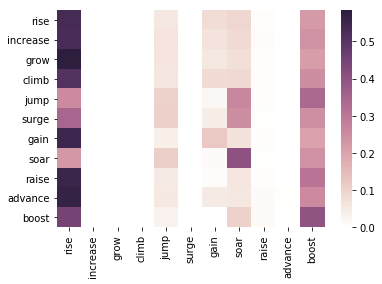

In [12]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
f = sns.heatmap(rise_con_scaling, cmap=cmap)
# f = sns.heatmap(rise_con_scaling)
f.figure.savefig('fig/heatmap_argmax_rise.pdf', bbox_inches='tight')

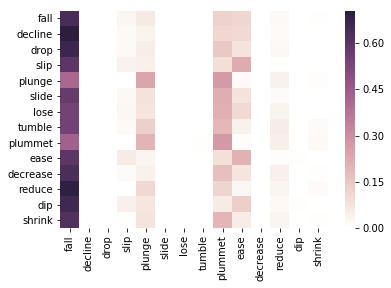

In [13]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
f = sns.heatmap(fall_con_scaling, cmap=cmap)
# f = sns.heatmap(fall_con_scaling)
f.figure.savefig('fig/heatmap_argmax_fall.pdf', bbox_inches='tight')